## Predicting using Deployed Cnvrg Model
Once the model has been served using cnvrg's serving feature, images can be sent and inferenced through an API exposed by cnvrg

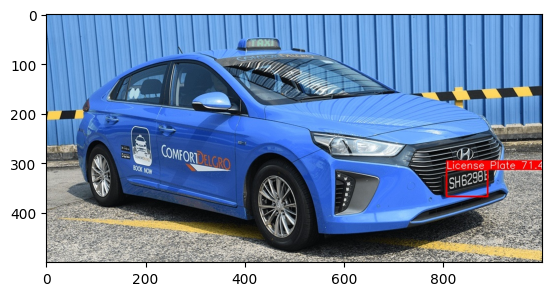

In [1]:
import http.client
import requests
import json
import base64
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline



image = cv2.imread("test-images/01.png")
jpg_as_text = base64.b64encode(cv2.imencode('.jpg', image)[1]).decode()

conn = http.client.HTTPSConnection("predictlp-1.mlops.cnasg.dellcsc.com", 443)

# payload = "{\"input_params\": \"" + image.tostring() + "\"}"

payload = {
    'input_params': jpg_as_text
}

headers = {
    'Cnvrg-Api-Key': "v6TWhXvtJNoRF63cSgmdoa5C",
    'Content-Type': "application/json"
    }


conn.request("POST", "/api/v1/endpoints/gzwyuneut7xvyvskqfme", json.dumps(payload), headers)

res = conn.getresponse()
data = res.read()
data_formatted = json.loads(data.decode("utf-8"))
pred_image_encoded = data_formatted['prediction']
pred_image = base64.b64decode(pred_image_encoded)
pred_image_np = np.frombuffer(pred_image, dtype=np.uint8)
# img = cv2.cvtColor(cv2.imdecode(pred_image_np, flags=1), cv2.COLOR_BGR2RGB)
img = cv2.imdecode(pred_image_np, flags=1)

plt.imshow(img)
plt.show()
# print(data.decode("utf-8"))